# Preamble

In [1]:
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
from pprint import pprint
import tinydb as db
from tinydb.storages import MemoryStorage
import pdb
import pygama.utils as pgu

import matplotlib
# matplotlib.use('Agg') # when running on cori
import matplotlib.pyplot as plt
#plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import psd_analysis as psd

import calibration_jdetwiler as cb


dg = DataGroup('/global/homes/f/fnafis/krstc/krstc.json', load=True)
    
fontsize = 20  
def draw_canvas(plt, fontsize=fontsize, xlabel='xlabel', ylabel='count', title='title'):
    plt.figure(figsize=(20,16))
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize*1.5)
    plt.ylabel(ylabel, fontsize=fontsize*1.5)
    plt.legend(fontsize=fontsize)
    plt.title(title, fontsize=fontsize*2)

# dt histogram 
dt = time difference between successive events
   = time difference between rise of waveforms of successive events

loading data for /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run3_cyc2040_dsp.lh5


<ipython-input-2-5a579b21d22f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hit['dt'][i+1] = dt_clockticks/1e5 #converted to milliseconds
No handles with labels found to put in legend.


,trapEmax,bl,bl_sig,A_10,timestamp,trapEmax_cal,dt
0,422.138397,58089.277344,4.044410,28.733501,1360901,181.419724,0.00000
1,6.908443,58089.714844,4.010944,2.400633,2051748,2.870841,6.90847
2,165.633667,58088.406250,4.504540,11.215175,2394761,71.122688,3.43013
3,286.623230,58090.574219,4.227704,19.625355,3868273,123.148201,14.73512
4,3800.482422,58087.238281,3.894429,257.704346,6781069,1634.107788,29.12796
...,...,...,...,...,...,...,...
121957,152.856766,58090.839844,4.567903,5.508103,155373560179,65.628616,3.37783
121958,980.814819,58094.140625,4.172520,68.376511,155374198251,421.650574,6.38072
121959,2172.284180,58094.746094,4.151340,101.615524,155375870484,933.982422,16.72233
121960,173.211960,57997.730469,4.422466,12.112050,155375909558,74.381355,0.39074


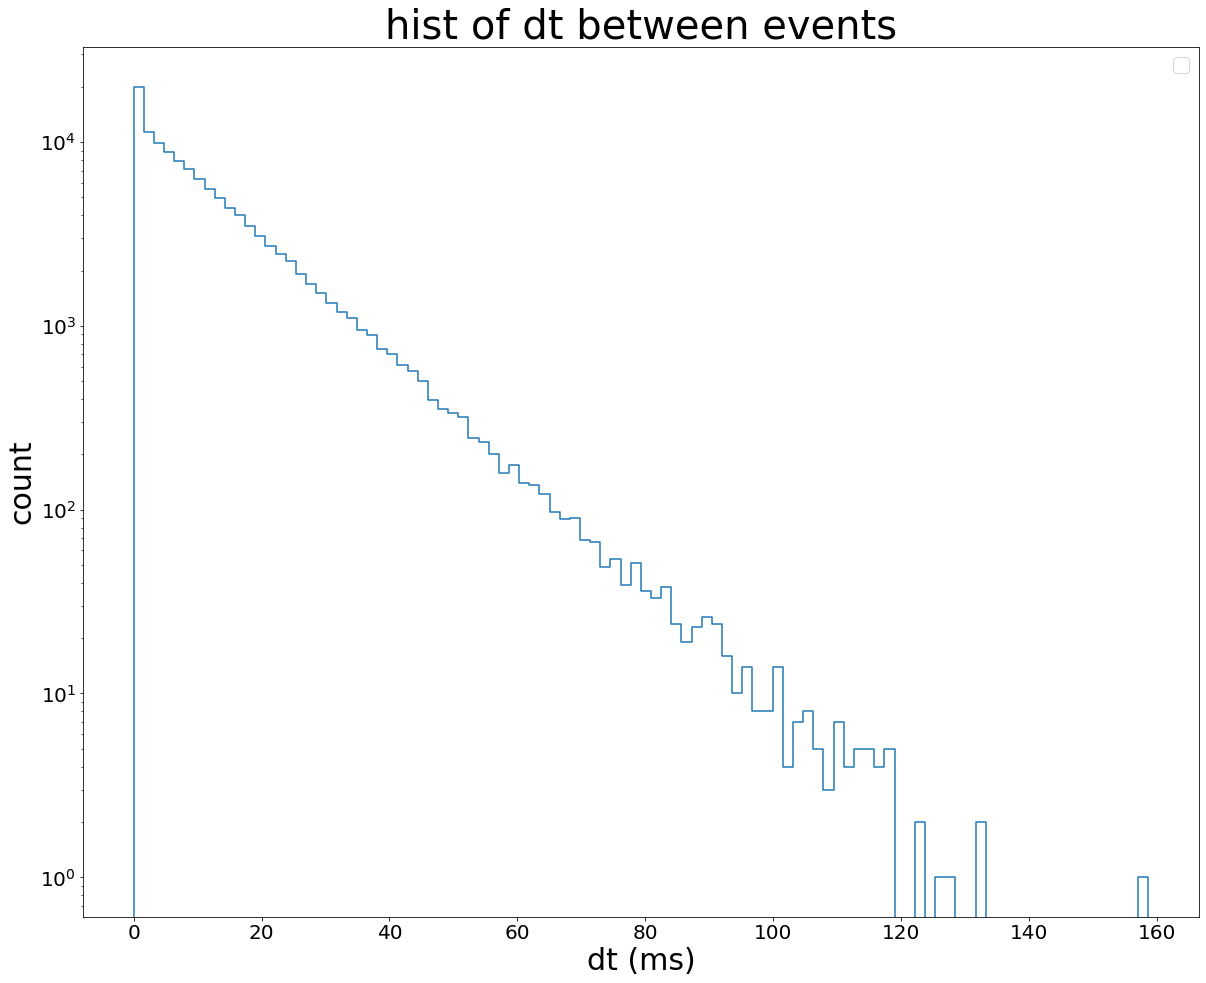

In [2]:
beginning_cycle = 2019
#cycle_range = [2028,2038, 'bkg'] #run 2
cycle_range = [2040,2041, 'kry'] #run 3
#cycle_range = [2028,2029, 'Run2'] #run 7


lh5_dir = dg.lh5_dir
dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']


hit_list = dsp_list[cycle_range[0]-beginning_cycle:cycle_range[1]-beginning_cycle]

#hit_list = dsp_list[2039-2019]
'''
columns in file:
        ['trapE', 'bl', 'bl_sig', 'A_10', 'AoE', 'packet_id', 'ievt', 'energy',
        'energy_first', 'timestamp', 'crate', 'card', 'channel', 'energy_cal',
        'trapE_cal']'''


df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'bl', 'bl_sig', 'A_10', 'timestamp'], 'ORSIS3302DecoderForEnergy/dsp')
#timestamp is in unit of 10ns.
#current_pars = [0.4494, 0.1825]
current_pars = [0.430, -0.09979]
df_hit['trapEmax_cal'] = np.polyval(current_pars, df_hit['trapEmax'])

#adding dt to the dataframe in unit of nanoseconds
df_hit['dt']=0.0 #dt column will be in float
for i in range(len(df_hit)-1):
    dt_clockticks = (df_hit['timestamp'][i+1]-df_hit['timestamp'][i]) #clockticks
    df_hit['dt'][i+1] = dt_clockticks/1e5 #converted to milliseconds
    
dt_n_bins = 100
dt_hist, dt_bins, dt_var = pgh.get_hist(df_hit['dt'], bins=dt_n_bins)
draw_canvas(plt, xlabel='dt (ms)', ylabel='count', title='hist of dt between events')
pgh.plot_hist(dt_hist,dt_bins)
plt.yscale('log')


df_hit

No handles with labels found to put in legend.


total area =  193415.97450960003
area = 160892.93614320006
[-0.07424906  9.45409498]


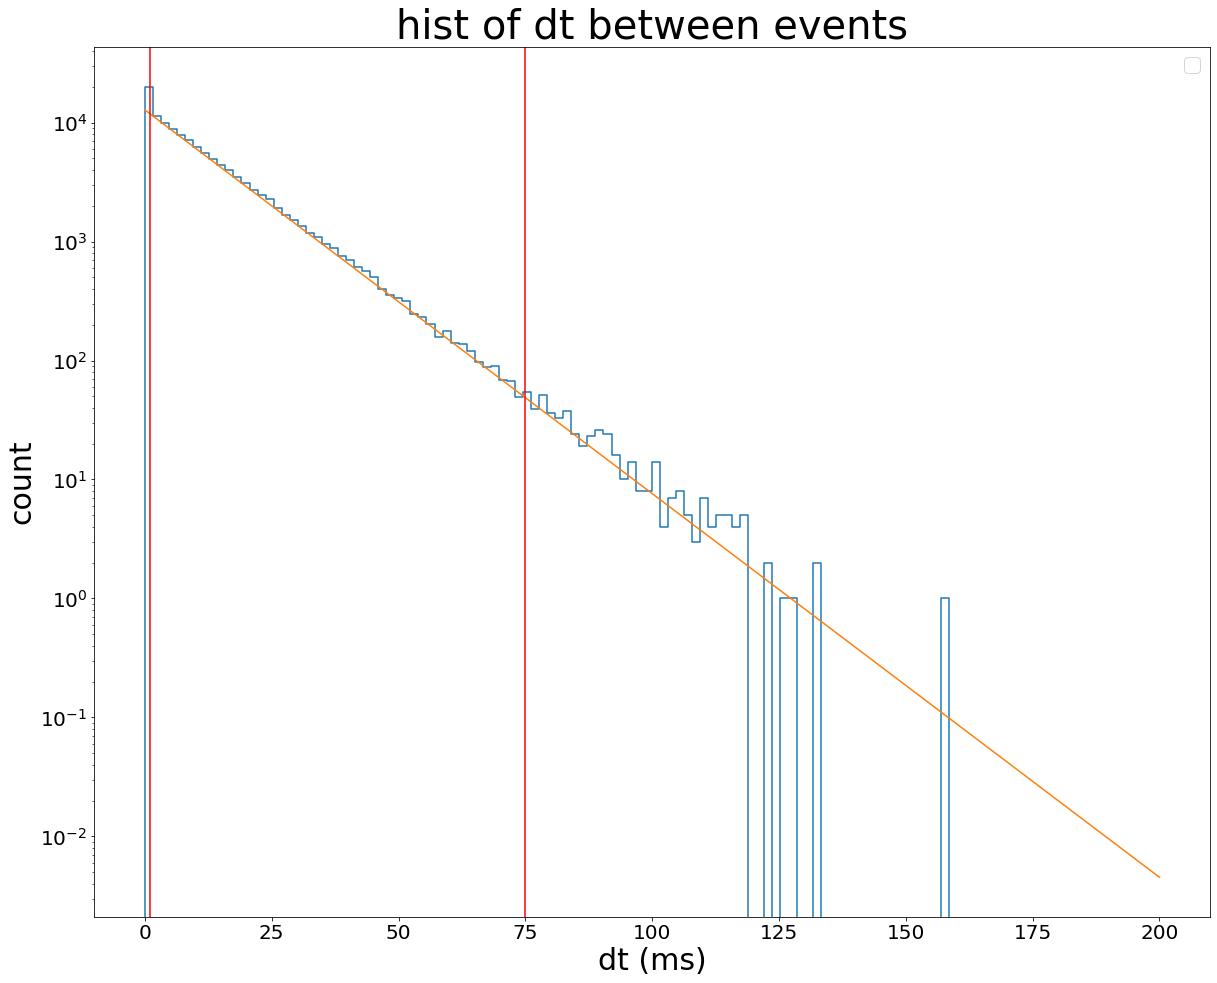

In [3]:
dt_range = [1,75] #milliseconds
bin_range = np.digitize(dt_range, dt_bins)
dt_bins_new = dt_bins[bin_range[0]:bin_range[1]+1]
dt_hist_new = dt_hist[bin_range[0]:bin_range[1]]
area = sum(np.diff(dt_bins_new)*dt_hist_new)
print('total area = ',sum(np.diff(dt_bins)*dt_hist))
print('area =',area)
params = np.polyfit(dt_bins_new[:-1],np.log(dt_hist_new), deg=1)
print(params)
draw_canvas(plt, xlabel='dt (ms)', ylabel='count', title='hist of dt between events')
pgh.plot_hist(dt_hist,dt_bins)
plt.yscale('log')
x = np.linspace(0,200)
y = np.exp(x*params[0]+params[1])
plt.plot(x,y)
plt.axvline(dt_range[0], color='r')
plt.axvline(dt_range[1], color='r')

No handles with labels found to put in legend.


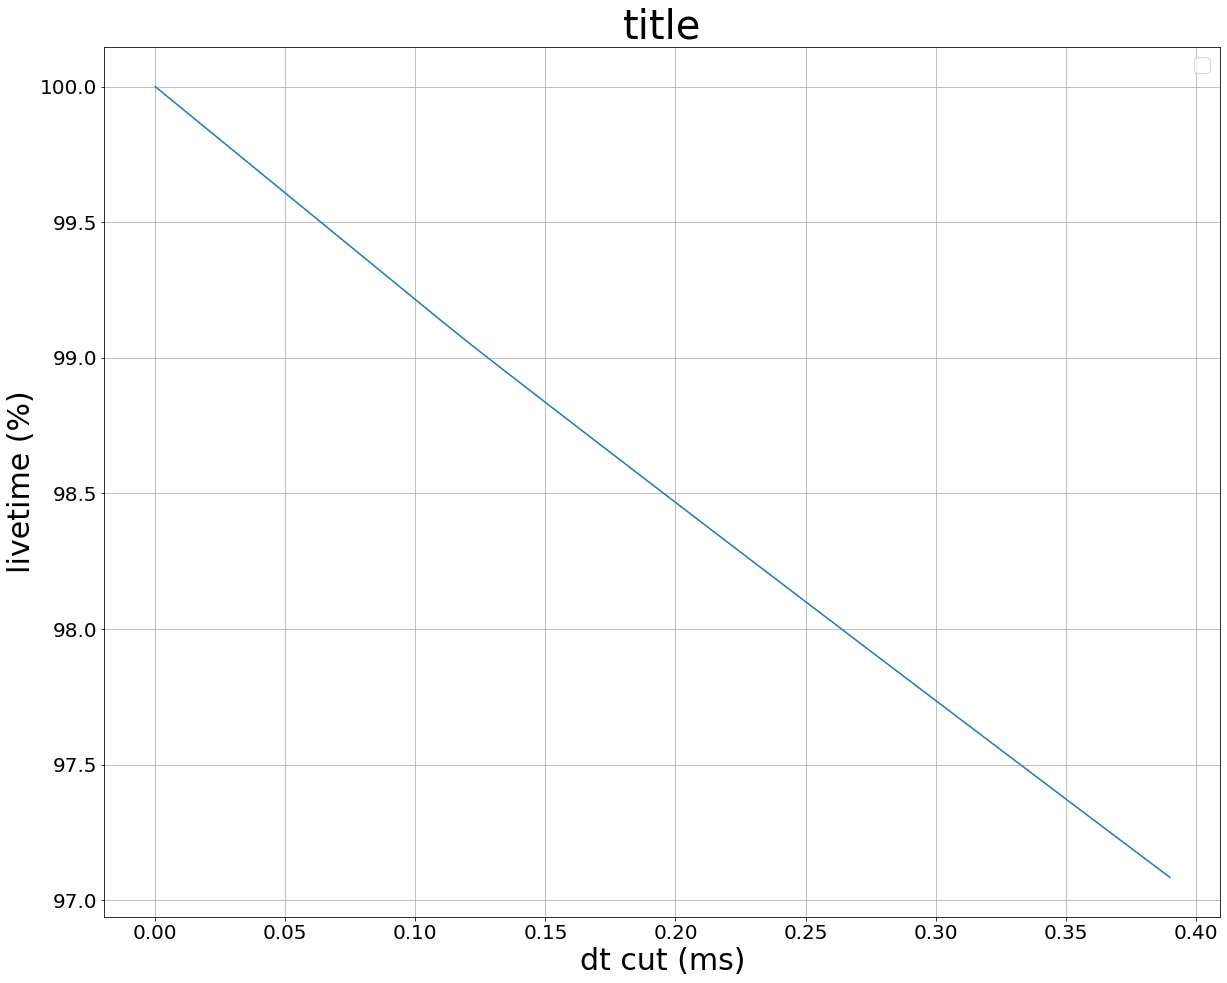

In [4]:
cut_passed=0
dt_cut_vals = []
livetimes = []
for dt_cut in np.arange(0,0.4,0.01):
    livetime = 0
    dt_cut_vals.append(dt_cut)
    for i in range(len(df_hit)):
        dt = df_hit['dt'][i]
        if(dt>dt_cut):
            cut_passed = cut_passed + 1
            livetime = livetime + (dt-dt_cut) #so livetime in milliseconds
    #livetime = livetime/(1000*60) #converted to mins
    livetimes.append(livetime)
    #print('cut passed: ',cut_passed)
    #print('livetime: ',livetime)

max_livetime = max(livetimes)
percent_livetimes = livetimes/max_livetime*100
draw_canvas(plt, xlabel='dt cut (ms)', ylabel='livetime (%)')
plt.plot(dt_cut_vals, percent_livetimes)
plt.grid()

No handles with labels found to put in legend.


(0.0, 10.0)

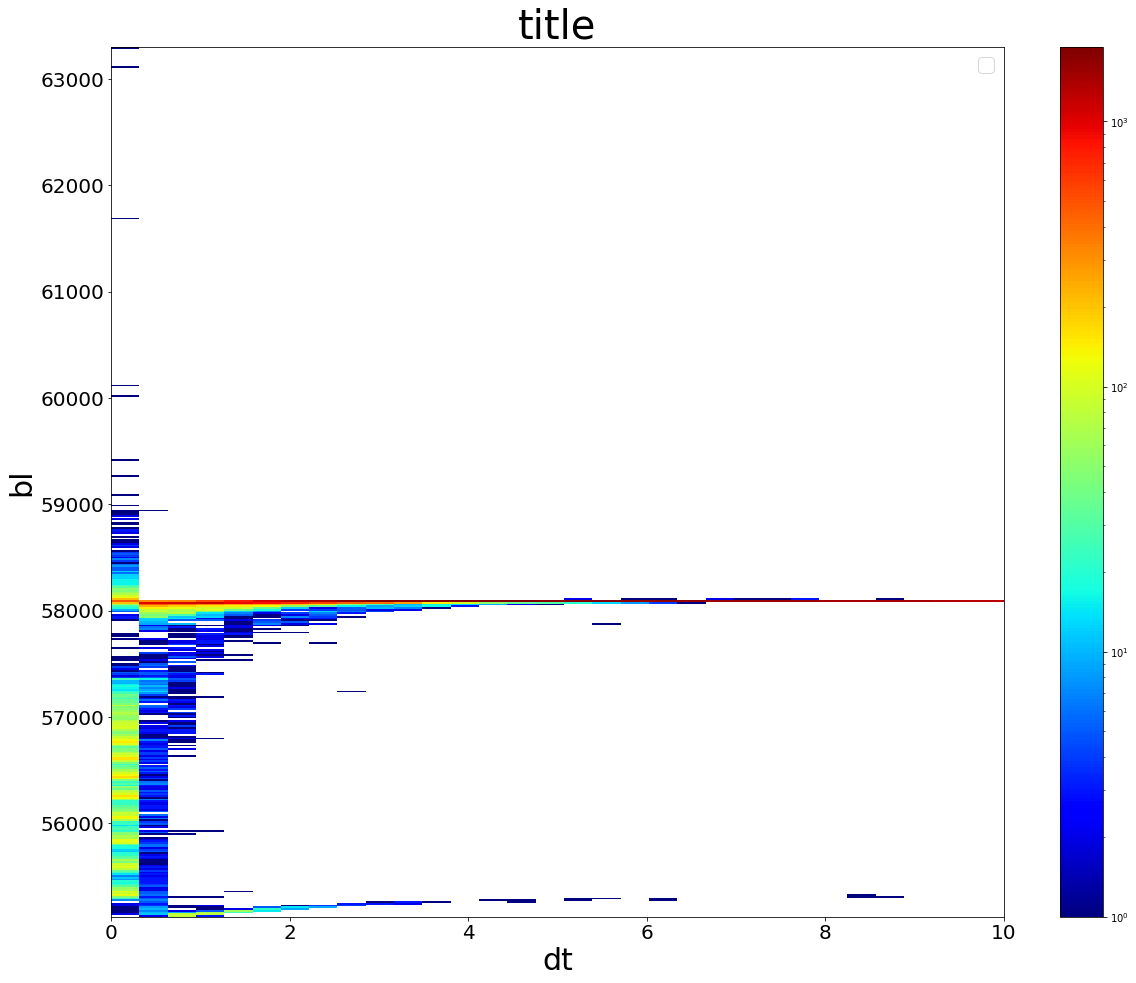

In [5]:
ylabel = 'bl'
#ylabel = 'trapEmax'
draw_canvas(plt, xlabel='dt', ylabel=ylabel)
h = plt.hist2d(df_hit['dt'], df_hit[ylabel], cmap='jet', 
               norm=matplotlib.colors.LogNorm(), bins=[500,500])

colorbar = plt.colorbar(h[3], ax=plt.gca())

plt.xlim(0,10)

### Why is the time difference between events important?
A: events happening too close to previous one will not have well defined baseline and also affect the topline (=trapEmax) of the previous one, that's why. Also infact these too close happening events make the topline slope down instead of staying constant.

### Energy spectrum for dt cuts

No handles with labels found to put in legend.


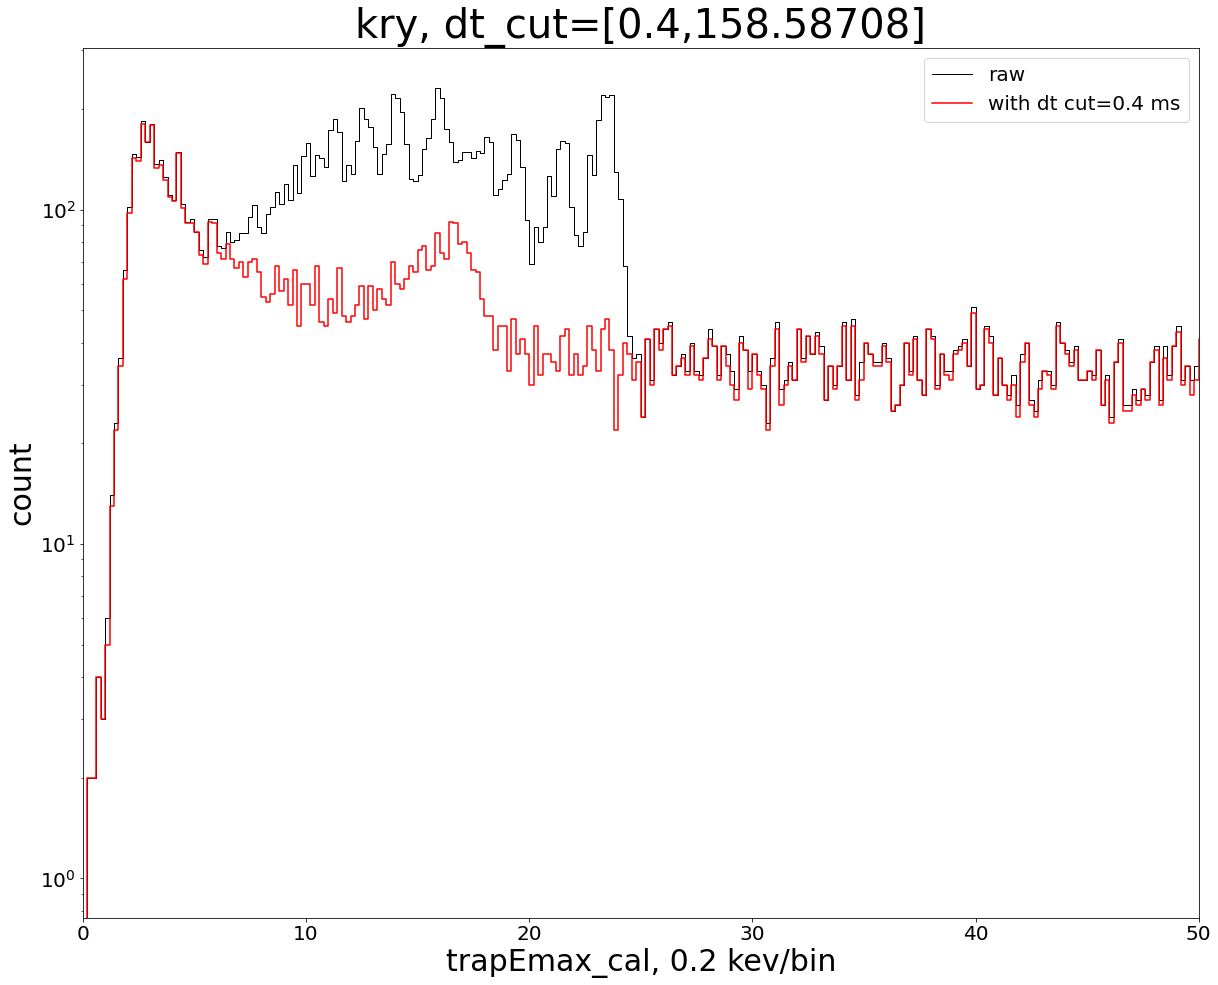

In [6]:
dt_cut_point = 0.4 #millisecond
dt_cut_range = [dt_cut_point, max(df_hit['dt'])]
dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
etype='trapEmax_cal'

elo = 0
ehi = 4000

n_bins = 4000*5

kev_per_bin = (ehi-elo)/n_bins

draw_canvas(plt, xlabel=etype+', '+ str(kev_per_bin)+' kev/bin', ylabel='count', title=cycle_range[2]+', dt_cut=['+
      str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')



h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
#x1 = x1[2:]
pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
plt.yscale('log')


h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax_cal'], range=(elo, ehi), bins=n_bins)
pgh.plot_hist(h2,x2, color='r', label='with dt cut='+str(dt_cut_point)+' ms')
plt.yscale('log')
plt.xlim(0,50)

plt.legend(fontsize=fontsize)

### fitting gauss(mu,sigma,A) + [bkg] + step[x1,x2]

In [7]:
def goodness_of_fit(hist, bins, var, func, pars, method='var'):
    """ Compute chisq and dof of fit

    Parameters
    ----------
    hist, bins, var : array, array, array or None
        histogram data. var can be None if hist is integer counts
    func : function
        the function that was fit to the hist
    pars : array
        the best-fit pars of func. Assumes all pars are free parameters
    method : str
        Sets the choice of "denominator" in the chi2 sum
        'var': user passes in the variances in var (must not have zeros)
        'Pearson': use func (hist must contain integer counts)
        'Neyman': use hist (hist must contain integer counts and no zeros)

    Returns
    -------
    chisq : float
        the summed up value of chisquared
    dof : int
        the number of degrees of freedom
    """
    # arg checks
    if method == 'var':
        if var is None:
            print("goodness_of_fit: var must be non-None to use method 'var'")
            return 0, 0
        if np.any(var==0):
            print("goodness_of_fit: var cannot contain zeros")
            return 0, 0
    if method == 'Neyman' and np.any(hist==0):
        print("goodness_of_fit: hist cannot contain zeros for Neyman method")
        return 0, 0

    # compute chi2 numerator and denominator
    
    yy = func(pgh.get_bin_centers(bins), *pars)
    numerator = (hist - yy)**2
    if method == 'var':
        denominator = var
    elif method == 'Pearson':
        denominator = yy
    elif method == 'Neyman':
        denominator = hist
    else:
        print(f"goodness_of_fit: unknown method {method}")
        return 0, 0

    # compute chi2 and dof 
    chisq = np.sum(numerator/denominator)
    dof = len(hist) - len(pars)
    return chisq, dof

In [8]:
def fitting_func(x,mu, sigma, height=1, bkg=0, step_factor=-15):
    gaussian = height * np.exp(-(x - mu)**2 / (2. * sigma**2)) + bkg + step_factor*np.heaviside((x-mu), 1)
    return gaussian

def fit_gauss_bkg_step(df_hit=df_hit, ene_range=[0,4000], dt_cut_point=0.4, etype='trapEmax_cal', 
                      plot=False, verbose=False, fitting_ene_range=[1400,1500], 
                      guessed_params=(1460.0, 1.0, 110, 5, -15), poissonLL=False):
    
    #dt_cut_point = 0.4 #millisecond
    dt_cut_range = [dt_cut_point, max(df_hit['dt'])]
    dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
    #etype='trapEmax_cal'
    #draw_canvas(plt, xlabel='trapEmax', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    elo = ene_range[0]
    ehi = ene_range[1]

    n_bins = (ehi-elo)*5

    kev_per_bin = (ehi-elo)/n_bins


    h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal[etype], range=(elo, ehi), 
                              bins=n_bins)

    #fitting_ene_range = [1400,1500]
    fitting_bin_range = np.digitize(fitting_ene_range, x2)
    if verbose: print(fitting_bin_range)

    fitting_hist = h2[fitting_bin_range[0]:fitting_bin_range[1]]
    fitting_bins = x2[fitting_bin_range[0]:fitting_bin_range[1]+1]
    fitting_var = v2[fitting_bin_range[0]:fitting_bin_range[1]]

    n_sigma = 5
    imax, imin = cb.get_i_local_extrema(fitting_hist/np.sqrt(fitting_var), n_sigma)
    if verbose: print('Max at: ',fitting_bins[imax])
    if verbose: print(len(fitting_bins))
    fitting_bin_centers = pgh.get_bin_centers(fitting_bins)


    '''
    pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(fitting_hist, fitting_bins, fitting_var, [356.5],
                                               n_to_fit=n_sigma, poissonLL=[False])

    fitting_sigma = pt_pars[0][1]
    print('pt_pars: ', pt_pars)
    '''
    #pars, covs = curve_fit(fitting_func, fitting_bins, fitting_hist)
    #guessed_params = (1460.0, 1.0, 110, 5, -15)
    pars, covs = pgf.fit_hist(fitting_func, fitting_hist, fitting_bins, fitting_var, 
                              guess=guessed_params, poissonLL=poissonLL)
    if verbose: print('pars:',pars)

    if plot==True:
        draw_canvas(plt, xlabel=etype+', '+ str(kev_per_bin)+' kev/bin', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
    print(h1[0:5],v1[0:5])
    #x1 = x1[2:]
    if plot==True:
        pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
        plt.yscale('log')
        pgh.plot_hist(h2,x2, color='r', label='with dt cut='+str(dt_cut_point)+' ms')
        plt.yscale('log')
        plt.xlim(fitting_ene_range[0],fitting_ene_range[1])
        #pgu.plot_func(fitting_func, pars, range=(fitting_ene_range[0],fitting_ene_range[1]), label='Gauss+bkg+step')
        pgu.plot_func(fitting_func, pars, range=(fitting_ene_range[0],fitting_ene_range[1]),
                 label='Gauss+bkg+step')
    #calculating chi square
    #x = np.arange(355,358,0.1)
    fitting_bin_centers = pgh.get_bin_centers(fitting_bins)
    '''
    chisquare = stats.chisquare(fitting_hist, 
                                f_exp=fitting_func(fitting_bin_centers, *pars))[0]
    print(chisquare)
    chisquare = 0.0
    chisquare2 = 0.0
    for i, j in enumerate(range(len(fitting_bin_centers))):
        a = fitting_hist[j]
        b = fitting_func(fitting_bin_centers[j], *pars)
        #error = np.sqrt(Ba_var[j])
        chisquare = chisquare + ((a-b)**2)/fitting_var[j]
        chisquare2 = chisquare2 + ((a-b)**2)/b
        if i < 10:
            print(i, j, chisquare, chisquare2)

    dof = len(fitting_bin_centers)-1-2
    chisquare_per_dof = chisquare/dof
    '''
    chisqaure, dof = goodness_of_fit(fitting_hist, fitting_bins, fitting_var, 
                                  fitting_func, pars, method='Pearson')
    chisquare_per_dof = chisqaure/dof
    if verbose: print('chi2/dof=',chisquare_per_dof)
    if plot==True:
        plt.legend(fontsize=20)
    return pars, covs, chisquare_per_dof
    
pars, covs, chi2_per_dof = fit_gauss_bkg_step(df_hit=df_hit, dt_cut_point=0.4, 
                                              verbose=True, plot=True, 
                   guessed_params=(1460.0, 1.0, 110, 5, -15),
                   fitting_ene_range=[1400,1500], poissonLL=False)
print(covs)

[7001 7501]


<ipython-input-8-919fdf6dce46>:36: RuntimeWarning: invalid value encountered in true_divide
  imax, imin = cb.get_i_local_extrema(fitting_hist/np.sqrt(fitting_var), n_sigma)


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
new_guessed_params = (pars[0],pars[1],pars[2], pars[3], pars[4])
fit_gauss_bkg_step(df_hit=df_hit, dt_cut_point=0.4, 
                                              verbose=True, plot=True, 
                   guessed_params=new_guessed_params,
                   fitting_ene_range=[1400,1500], poissonLL=False)

In [ ]:
dt_cuts = []
chisquare_per_dofs = []
for i in np.arange(0,1,0.05):
    dt_cut_point = i #millisecond
    dt_cuts.append(dt_cut_point)
    dt_cut_range = [dt_cut_point, max(df_hit['dt'])]
    dt_cut_ene_cal = df_hit[(df_hit['dt']>dt_cut_range[0]) & (df_hit['dt']<dt_cut_range[1])]
    etype='trapEmax_cal'
    #draw_canvas(plt, xlabel='trapEmax', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    elo = 0
    ehi = 4000

    n_bins = 4000*5

    kev_per_bin = (ehi-elo)/n_bins


    h2, x2, v2 = pgh.get_hist(dt_cut_ene_cal['trapEmax_cal'], range=(elo, ehi), 
                              bins=n_bins)

    fitting_ene_range = [1400,1500]
    fitting_bin_range = np.digitize(fitting_ene_range, x2)
    #print(fitting_bin_range)

    fitting_hist = h2[fitting_bin_range[0]:fitting_bin_range[1]]
    fitting_bins = x2[fitting_bin_range[0]:fitting_bin_range[1]+1]
    fitting_var = v2[fitting_bin_range[0]:fitting_bin_range[1]]

    n_sigma = 5
    imax, imin = cb.get_i_local_extrema(fitting_hist/np.sqrt(fitting_var), n_sigma)
    #print('Max at: ',fitting_bins[imax])
    #print(len(fitting_bins))
    fitting_bin_centers = pgh.get_bin_centers(fitting_bins)


    '''
    pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(fitting_hist, fitting_bins, fitting_var, [356.5],
                                               n_to_fit=n_sigma, poissonLL=[False])

    fitting_sigma = pt_pars[0][1]
    print('pt_pars: ', pt_pars)
    '''
    #pars, covs = curve_fit(fitting_func, fitting_bins, fitting_hist)
    guessed_params = (1460.0, 1.0, 110, 5, -15)
    pars, covs = pgf.fit_hist(fitting_func, fitting_hist, fitting_bins, fitting_var, 
                              guess=guessed_params)
    #print('pars:',pars)

    #draw_canvas(plt, xlabel=etype+', '+ str(kev_per_bin)+' kev/bin', ylabel='count', title=cycle_range[2]+', dt_cut=['+
          #str(dt_cut_range[0])+','+ str(dt_cut_range[1])+']')

    h1, x1, v1 = pgh.get_hist(df_hit[etype], range=(elo, ehi), bins=n_bins)
    #x1 = x1[2:]
    #pgh.plot_hist(h1, x1, c='k', lw=1, label='raw')
    #plt.yscale('log')


    #pgh.plot_hist(h2,x2, color='r', label='with dt cut='+str(dt_cut_point)+' ms')
    #plt.yscale('log')
    #plt.xlim(335,365)
    #pgu.plot_func(fitting_func, pars, range=(fitting_ene_range[0],fitting_ene_range[1]), label='Gauss+bkg+step')
    #pgu.plot_func(fitting_func, pars, range=(335,365),
                 #label='Gauss+bkg+step')
    #calculating chi square
    #x = np.arange(355,358,0.1)
    fitting_bin_centers = pgh.get_bin_centers(fitting_bins)
    '''
    chisquare = stats.chisquare(fitting_hist, 
                                f_exp=fitting_func(fitting_bin_centers, *pars))[0]
    print(chisquare)
    chisquare = 0.0
    chisquare2 = 0.0
    for i, j in enumerate(range(len(fitting_bin_centers))):
        a = fitting_hist[j]
        b = fitting_func(fitting_bin_centers[j], *pars)
        #error = np.sqrt(Ba_var[j])
        chisquare = chisquare + ((a-b)**2)/fitting_var[j]
        chisquare2 = chisquare2 + ((a-b)**2)/b
        if i < 10:
            print(i, j, chisquare, chisquare2)

    dof = len(fitting_bin_centers)-1-2
    chisquare_per_dof = chisquare/dof
    '''
    chisqaure, dof = goodness_of_fit(fitting_hist, fitting_bins, fitting_var, 
                                  fitting_func, pars, method='Pearson')
    chisquare_per_dof = chisqaure/dof
    chisquare_per_dofs.append(chisquare_per_dof)
    #print('chi2/dof=',chisquare_per_dof)
    #plt.legend(fontsize=20)
print("\n".join("{} {}".format(x, y) for x, y in zip(dt_cuts, chisquare_per_dofs)))
draw_canvas(plt, xlabel='dt cuts (ms)', ylabel='chi2/dof')
plt.plot(dt_cuts, chisquare_per_dofs)

# Pole-zero correction

In [ ]:
def exp_decay_func(x,A,tau, C):
    return A*np.exp(-x/tau)+C

raw_list = dg.lh5_dir + dg.fileDB['raw_path']+'/'+dg.fileDB['raw_file']
f_raw = raw_list[9]
print(f_raw)
raw_store = lh5.Store()
tb_name = 'ORSIS3302DecoderForEnergy/raw'
data_raw, nrows = raw_store.read_object(tb_name, f_raw)
bulk_wfs = data_raw['waveform']['values'].nda

wf = bulk_wfs[1]
clockticks = np.arange(0, bulk_wfs.shape[1], 1)
time = clockticks/100 #in us
draw_canvas(plt, xlabel='time (us)', ylabel='ADC')
plt.plot(time, wf)

max_index = np.argmax(wf)+200
last_index = len(wf)-100
extra = 3000
decay_part_of_wf = wf[max_index:last_index]
decay_part_of_time = time[max_index:last_index+1]
len(decay_part_of_wf)


pars, covs = pgf.fit_hist(exp_decay_func, decay_part_of_wf, decay_part_of_time, 
                          guess = (50,50, 58080))
#pars, covs = curve_fit(exp_decay_func, time, wf)
print(pars)


plt.plot(decay_part_of_time, pars[0]*np.exp(-decay_part_of_time/pars[1])+pars[2], color='r')

In [ ]:
np.argmax(wf)

In [ ]:
len(bulk_wfs)

In [ ]:
time_constants = []
trapEmax_cals = []
for i in range(100):
    if i%1000==0: print(i)
    trapEmax_cal = df_hit['trapEmax_cal'][i]
    if (trapEmax_cal>500 and trapEmax_cal<3500):
        try:
            
            wf = bulk_wfs[i]
            clockticks = np.arange(0, bulk_wfs.shape[1], 1)
            time = clockticks/100
            max_index = np.argmax(wf)+200
            last_index = len(wf)-200
            extra = 3000
            decay_part_of_wf = wf[max_index:last_index]
            decay_part_of_time = time[max_index:last_index+1]



            pars, covs = pgf.fit_hist(exp_decay_func, decay_part_of_wf, decay_part_of_time, guess = (50,50, 58080))
            #pars, covs = curve_fit(exp_decay_func, time, wf)
            #print(pars[1])
            time_constants.append(pars[1])
            trapEmax_cals.append(trapEmax_cal)


            print(trapEmax_cals[i],time_constants[i])

        except:
            pass


    #plt.plot(decay_part_of_time, pars[0]*np.exp(-decay_part_of_time/pars[1])+pars[2], color='r')
draw_canvas(plt, xlabel='trapEmax_cal',ylabel='time_constants')
plt.plot(trapEmax_cals,time_constants, linestyle='None', marker='o')
plt.ylim(-100,100)

In [ ]:
len(trapEmax_cals)

In [ ]:
len(time_constants)

In [ ]:
a=[1,3,6,3,4]
#np.where(a>3)[0]
#a=np.delete(a,[1,2])
type(a)

a
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]
find_indices(a,lambda e: e>3)

In [ ]:
def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

            
ind = [0,2]
delete_multiple_element(a,ind)
a

In [ ]:
indices_to_delete = find_indices(time_constants, lambda e:(e<0 and e>1000))
delete_multiple_element(time_constants,indices_to_delete)
delete_multiple_element(trapEmax_cals, indices_to_delete)
plt.plot(trapEmax_cals, time_constants)

In [ ]:
data_raw['waveform']['values'].nda[3]

In [ ]:
df_hit['trapEmax_cal'][30]